In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer, KNNImputer

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/reviews.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Display the first few rows of the dataset
print(df.head())

   Unnamed: 0   Airline Name Overall_Rating  \
0           0    AB Aviation              9   
1           1    AB Aviation              1   
2           2    AB Aviation              1   
3           3  Adria Airways              1   
4           4  Adria Airways              1   

                            Review_Title          Review Date  Verified  \
0                "pretty decent airline"   11th November 2019      True   
1                   "Not a good airline"       25th June 2019      True   
2         "flight was fortunately short"       25th June 2019      True   
3    "I will never fly again with Adria"  28th September 2019     False   
4  "it ruined our last days of holidays"  24th September 2019      True   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an... 

In [ ]:
# Filter the dataset to include only verified reviews
df = df[df['Verified'] == True]

In [ ]:
# Check for missing values
print(df.isnull().sum().max())

8492


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
Airline Name,0
Overall_Rating,0
Review_Title,0
Review Date,0
Verified,0
Review,0
Aircraft,7846
Type Of Traveller,1
Seat Type,0


In [ ]:
# Drop rows with missing values
df.dropna(subset=['Review'], inplace=True)


<ipython-input-7-0fb9431561dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Review'], inplace=True)


In [ ]:
# Droping irrelevant columns
df.drop(columns=['Unnamed: 0', 'Airline Name','Review Date', 'Aircraft',
                 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown'], inplace=True)

<ipython-input-8-50f33374782a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Unnamed: 0', 'Airline Name','Review Date', 'Aircraft',


In [ ]:
df.isnull().sum()

,0
Overall_Rating,0
Review_Title,0
Verified,0
Review,0
Seat Comfort,1230
Cabin Staff Service,1319
Food & Beverages,4148
Ground Service,710
Inflight Entertainment,6247
Wifi & Connectivity,8492


In [ ]:
# Impute missing values for columns with moderate missing values
imputer = KNNImputer(n_neighbors=5)
# Impute missing values for relevant columns using KNN imputation
imputer = KNNImputer(n_neighbors=5)
imputed_df = imputer.fit_transform(df[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages','Ground Service']])
df[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages','Ground Service']] = imputed_df

# Impute missing values for columns with very few missing values
df['Value For Money'].fillna(df['Value For Money'].mode()[0], inplace=True)

In [ ]:
df.isnull().sum()

,0
Overall_Rating,0
Review_Title,0
Verified,0
Review,0
Seat Comfort,0
Cabin Staff Service,0
Food & Beverages,0
Ground Service,0
Inflight Entertainment,6247
Wifi & Connectivity,8492


In [ ]:
# Creating binary indicators for highly missing data while keeping the original columns
for column in ['Inflight Entertainment', 'Wifi & Connectivity']:
    # Create a new column in df to indicate missingness
    df[column + '_missing'] = df[column].isnull().astype(int)

# This way, you preserve the original data where available and also capture the pattern of missingness
# You can now use both the actual data and the indicators in your analysis

# Display the DataFrame to verify the new columns
print(df.head())
print(df[['Inflight Entertainment', 'Inflight Entertainment_missing',
         'Wifi & Connectivity', 'Wifi & Connectivity_missing']].head())


  Overall_Rating                           Review_Title  Verified  \
0              9                "pretty decent airline"      True   
1              1                   "Not a good airline"      True   
2              1         "flight was fortunately short"      True   
4              1  "it ruined our last days of holidays"      True   
5              1              "Had very bad experience"      True   

                                              Review  Seat Comfort  \
0    Moroni to Moheli. Turned out to be a pretty ...           4.0   
1   Moroni to Anjouan. It is a very small airline...           2.0   
2    Anjouan to Dzaoudzi. A very small airline an...           2.0   
4   Do not book a flight with this airline! My fr...           1.0   
5    Had very bad experience with rerouted and ca...           1.0   

   Cabin Staff Service  Food & Beverages  Ground Service  \
0                  5.0               4.0             4.0   
1                  2.0               1.0    

In [ ]:
print(df.head())

  Overall_Rating                           Review_Title  Verified  \
0              9                "pretty decent airline"      True   
1              1                   "Not a good airline"      True   
2              1         "flight was fortunately short"      True   
4              1  "it ruined our last days of holidays"      True   
5              1              "Had very bad experience"      True   

                                              Review  Seat Comfort  \
0    Moroni to Moheli. Turned out to be a pretty ...           4.0   
1   Moroni to Anjouan. It is a very small airline...           2.0   
2    Anjouan to Dzaoudzi. A very small airline an...           2.0   
4   Do not book a flight with this airline! My fr...           1.0   
5    Had very bad experience with rerouted and ca...           1.0   

   Cabin Staff Service  Food & Beverages  Ground Service  \
0                  5.0               4.0             4.0   
1                  2.0               1.0    

In [ ]:
df.isnull().sum()

,0
Overall_Rating,0
Review_Title,0
Verified,0
Review,0
Seat Comfort,0
Cabin Staff Service,0
Food & Beverages,0
Ground Service,0
Inflight Entertainment,6247
Wifi & Connectivity,8492


In [ ]:
# Simple Imputation for Inflight Entertainment and Wifi & Connectivity
# We use a constant like -1 to denote missing values since these are ordinal ratings
simple_imputer = SimpleImputer(strategy='constant', fill_value=-1)
df[['Inflight Entertainment', 'Wifi & Connectivity']] = simple_imputer.fit_transform(
    df[['Inflight Entertainment', 'Wifi & Connectivity']])

# Verify the changes
print("Missing values after all imputations:\n", df.isnull().sum())

Missing values after all imputations:
 Overall_Rating                    0
Review_Title                      0
Verified                          0
Review                            0
Seat Comfort                      0
Cabin Staff Service               0
Food & Beverages                  0
Ground Service                    0
Inflight Entertainment            0
Wifi & Connectivity               0
Value For Money                   0
Recommended                       0
Inflight Entertainment_missing    0
Wifi & Connectivity_missing       0
dtype: int64


In [ ]:
# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Basic text cleaning function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = word_tokenize(text)  # Tokenize the text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]  # Remove stopwords and lemmatize
    return ' '.join(text)

# Apply the preprocessing function to the 'Review' column
df['Cleaned_Review'] = df['Review'].apply(clean_text)

# Display the cleaned review texts
print(df[['Review', 'Cleaned_Review']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                              Review  \
0    Moroni to Moheli. Turned out to be a pretty ...   
1   Moroni to Anjouan. It is a very small airline...   
2    Anjouan to Dzaoudzi. A very small airline an...   
4   Do not book a flight with this airline! My fr...   
5    Had very bad experience with rerouted and ca...   

                                      Cleaned_Review  
0  moroni moheli turned pretty decent airline onl...  
1  moroni anjouan small airline ticket advised tu...  
2  anjouan dzaoudzi small airline airline based c...  
4  book flight airline friend returned sofia amst...  
5  bad experience rerouted cancelled flight last ...  


In [ ]:
# Vectorize the cleaned text data
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['Cleaned_Review'])  # Use 'Cleaned_Review' here

# Vectorize the cleaned text data
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['Cleaned_Review'])  # Use 'Cleaned_Review' here

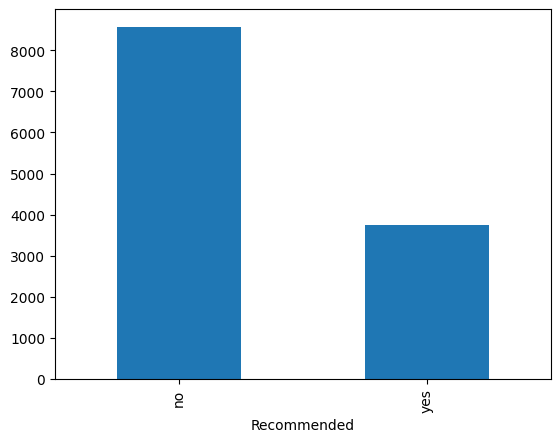

In [ ]:
# Basic statistics
df.describe()

# Count of reviews per sentiment (if applicable)
if 'Recommended' in df.columns:
    df['Recommended'].value_counts().plot(kind='bar')



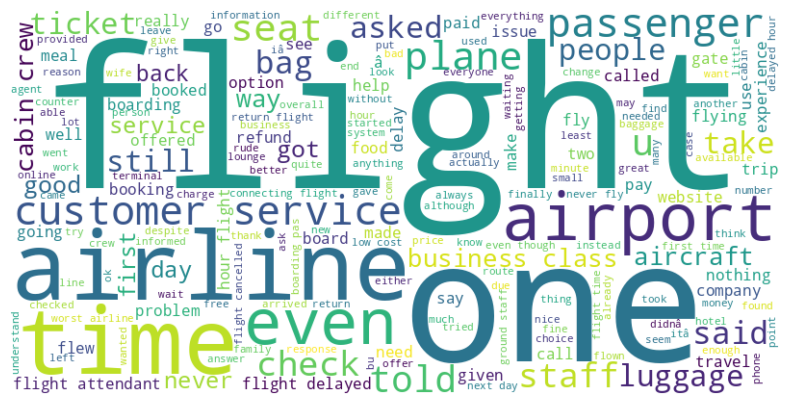

In [ ]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Cleaned_Review']))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [ ]:
# Assuming 'Recommended' is the target variable for sentiment (1 for positive, 0 for negative)
X = df['Cleaned_Review']
y = df['Recommended']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Create a pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')),
    ('clf', LogisticRegression())
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9290060851926978
              precision    recall  f1-score   support

          no       0.93      0.97      0.95      1685
         yes       0.93      0.84      0.88       780

    accuracy                           0.93      2465
   macro avg       0.93      0.90      0.92      2465
weighted avg       0.93      0.93      0.93      2465

